<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 4: Predict West Nile virus

---
## Problem Statement

West Nile virus is most commonly spread to humans through infected mosquitos. Around 20% of people who become infected with the virus develop symptoms ranging from a persistent fever, to serious neurological illnesses that can result in death. <img src="https://storage.googleapis.com/kaggle-competitions/kaggle/4366/media/moggie2.png" style="float: right">

In 2002, the first human cases of West Nile virus were reported in Chicago. By 2004 the City of Chicago and the Chicago Department of Public Health (CDPH) had established a comprehensive surveillance and control program that is still in effect today. 

Every week from late spring through the fall, mosquitos in traps across the city are tested for the virus. The results of these tests influence when and where the city will spray airborne pesticides to control adult mosquito populations.

Given weather, location, testing, and spraying data, this competition asks you to predict when and where different species of mosquitos will test positive for West Nile virus. A more accurate method of predicting outbreaks of West Nile virus in mosquitos will help the City of Chicago and CPHD more efficiently and effectively allocate resources towards preventing transmission of this potentially deadly virus. 

This [Kaggle competition](https://www.kaggle.com/c/predict-west-nile-virus/) is scored by AUC metric.

---
## Data description
In this competition, you will be analyzing weather data and GIS data and predicting whether or not West Nile virus is present, for a given time, location, and species. 

**Every year from late-May to early-October, public health workers in Chicago setup mosquito traps scattered across the city. Every week from Monday through Wednesday, these traps collect mosquitos, and the mosquitos are tested for the presence of West Nile virus** before the end of the week. The test results include the number of mosquitos, the mosquitos species, and whether or not West Nile virus is present in the cohort. 

#### Main dataset
These test results are organized in such a way that when the number of mosquitos exceed 50, they are split into another record (another row in the dataset), such that the number of mosquitos are capped at 50. 

The location of the traps are described by the block number and street name. For your convenience, we have mapped these attributes into Longitude and Latitude in the dataset. Please note that these are derived locations. For example, Block=79, and Street= "W FOSTER AVE" gives us an approximate address of "7900 W FOSTER AVE, Chicago, IL", which translates to (41.974089,-87.824812) on the map.

Some traps are "satellite traps". These are traps that are set up near (usually within 6 blocks) an established trap to enhance surveillance efforts. Satellite traps are postfixed with letters. For example, T220A is a satellite trap to T220. 

Please note that not all the locations are tested at all times. Also, records exist only when a particular species of mosquitos is found at a certain trap at a certain time. In the test set, we ask you for all combinations/permutations of possible predictions and are only scoring the observed ones.

#### Spray data
The City of Chicago also does spraying to kill mosquitos. You are given the GIS data for their spray efforts in 2011 and 2013. Spraying can reduce the number of mosquitos in the area, and therefore might eliminate the appearance of West Nile virus. 

![](https://storage.googleapis.com/kaggle-competitions/kaggle/4366/media/all_loc_trap.png)

#### Weather data
It is believed that hot and dry conditions are more favorable for West Nile virus than cold and wet. We provide you with the dataset from NOAA of the weather conditions of 2007 to 2014, during the months of the tests. Data dictionary for this dataset is found in [`noaa_weather_qclcd_documentation.pdf`](./assets/input/noaa_weather_qclcd_documentation.pdf)

    Station 1: 
    CHICAGO O'HARE INTERNATIONAL AIRPORT 
    Lat: 41.995 Lon: -87.933 
    Elev: 662 ft. above sea level
    
    Station 2: 
    CHICAGO MIDWAY INTL ARPT 
    Lat: 41.786 Lon: -87.752 
    Elev: 612 ft. above sea level

#### Map data
The map files `mapdata_copyright_openstreetmap_contributors.rds` and `mapdata_copyright_openstreetmap_contributors.txt` are from Open Streetmap and are primarily provided for use in visualizations (but you are allowed to use them in your models if you wish).

Here's an example using `mapdata_copyright_openstreetmap_contributors.rds`, and here's one using `mapdata_copyright_openstreetmap_contributors.txt`.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

sns.set_style('whitegrid')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

---
## Data

* [`clean_weather.csv`](./assets/input/clean_weather.csv)
* [`train.csv`](./assets/input/train.csv)

In [2]:
w_df = pd.read_csv('./assets/input/clean_weather.csv', parse_dates=[0], infer_datetime_format=True)
t_df = pd.read_csv('./assets/input/train.csv', parse_dates=[0], infer_datetime_format=True)
display(w_df.head(3))
display(t_df.head(3))

,Date,Station,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,...,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
0,2007-05-01,1,83,50,67,14,51,56,0,2,...,NaN,0,M,0.0,0.00,29.10,29.82,1.7,27,9.2
1,2007-05-01,2,84,52,68,M,51,57,0,3,...,NaN,M,M,M,0.00,29.18,29.82,2.7,25,9.6
2,2007-05-02,1,59,42,51,-3,42,47,14,0,...,BR,0,M,0.0,0.00,29.38,30.09,13.0,4,13.4


,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,1,0


In [3]:
# check date is datetime dtype
display(w_df.info())
display(t_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 22 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         2944 non-null   datetime64[ns]
 1   Station      2944 non-null   int64         
 2   Tmax         2944 non-null   int64         
 3   Tmin         2944 non-null   int64         
 4   Tavg         2944 non-null   object        
 5   Depart       2944 non-null   object        
 6   DewPoint     2944 non-null   int64         
 7   WetBulb      2944 non-null   object        
 8   Heat         2944 non-null   object        
 9   Cool         2944 non-null   object        
 10  Sunrise      2944 non-null   object        
 11  Sunset       2944 non-null   object        
 12  CodeSum      1335 non-null   object        
 13  Depth        2944 non-null   object        
 14  Water1       2944 non-null   object        
 15  SnowFall     2944 non-null   object        
 16  Precip

None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10506 entries, 0 to 10505
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Date                    10506 non-null  datetime64[ns]
 1   Address                 10506 non-null  object        
 2   Species                 10506 non-null  object        
 3   Block                   10506 non-null  int64         
 4   Street                  10506 non-null  object        
 5   Trap                    10506 non-null  object        
 6   AddressNumberAndStreet  10506 non-null  object        
 7   Latitude                10506 non-null  float64       
 8   Longitude               10506 non-null  float64       
 9   AddressAccuracy         10506 non-null  int64         
 10  NumMosquitos            10506 non-null  int64         
 11  WnvPresent              10506 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(4), ob

None

Doing this:
    
    # features Tavg and WetBulb not int64
    # to convert
    df.astype({'Tavg':'int64', 'WetBulb':'int64'}).dtypes # there are non integer values

Resulted in following error:   
    
    invalid literal for int() with base 10: 'M'

In [4]:
display(w_df.isnull().sum()) # null values in CodeSum feature
display(t_df.isnull().sum())

Date              0
Station           0
Tmax              0
Tmin              0
Tavg              0
Depart            0
DewPoint          0
WetBulb           0
Heat              0
Cool              0
Sunrise           0
Sunset            0
CodeSum        1609
Depth             0
Water1            0
SnowFall          0
PrecipTotal       0
StnPressure       0
SeaLevel          0
ResultSpeed       0
ResultDir         0
AvgSpeed          0
dtype: int64

Date                      0
Address                   0
Species                   0
Block                     0
Street                    0
Trap                      0
AddressNumberAndStreet    0
Latitude                  0
Longitude                 0
AddressAccuracy           0
NumMosquitos              0
WnvPresent                0
dtype: int64

In [5]:
display(w_df.shape)
display(t_df.shape)

(2944, 22)

(10506, 12)

In [6]:
w_df.set_index('Date', inplace=True) # set dates as index
t_df.set_index('Date', inplace=True)

In [7]:
w_df.sort_index(inplace=True) # just in case not sorted by date already
t_df.sort_index(inplace=True)

In [8]:
display(w_df.head(3))
display(t_df.head(3))

,Station,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,...,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
Date,,,,,,,,,,,,,,,,,,,,,
2007-05-01,1,83,50,67,14,51,56,0,2,0448,...,NaN,0,M,0.0,0.00,29.10,29.82,1.7,27,9.2
2007-05-01,2,84,52,68,M,51,57,0,3,-,...,NaN,M,M,M,0.00,29.18,29.82,2.7,25,9.6
2007-05-02,1,59,42,51,-3,42,47,14,0,0447,...,BR,0,M,0.0,0.00,29.38,30.09,13.0,4,13.4


,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent
Date,,,,,,,,,,,
2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,1,0


In [9]:
# plot comparison of weather stations location vs. trap locations
# to find out how to split the data between 2 regions
# function to plot data on map
def map_data():
    mapdata = np.loadtxt("./assets/input/mapdata_copyright_openstreetmap_contributors.txt")
    all_stations = pd.DataFrame({'station': [1,2],
                                 'latitude':[41.995, 41.786],
                                 'longitude':[-87.933, -87.752]}).set_index('station')
    all_traps = t_df[['Trap','Longitude', 'Latitude', 'WnvPresent']]

    # set up base map
    aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1]
    lon_lat_box = (-88.1, -87.5, 41.6, 42.05)

    plt.figure(figsize=(10,14))
    plt.imshow(mapdata, 
               cmap=plt.get_cmap('gray'), 
               extent=lon_lat_box, 
               aspect=aspect)
 
    # plot base data
    all_locations1 = all_stations[['longitude', 'latitude']].values
    all_locations2 = all_traps[['Longitude', 'Latitude']].drop_duplicates().values
    plt.scatter(all_locations1[0,0], all_locations1[0,1], marker='P', color='blue')
    plt.scatter(all_locations1[1,0], all_locations1[1,1], marker='D', color='red')
    plt.scatter(all_locations2[:,0], all_locations2[:,1], marker='X', color='green')
    plt.xlabel('longitude')
    plt.ylabel('latitude')
    plt.title('A Plot of weather stations')
    plt.legend(['station 1', 'station 2','traps'], loc='upper right');

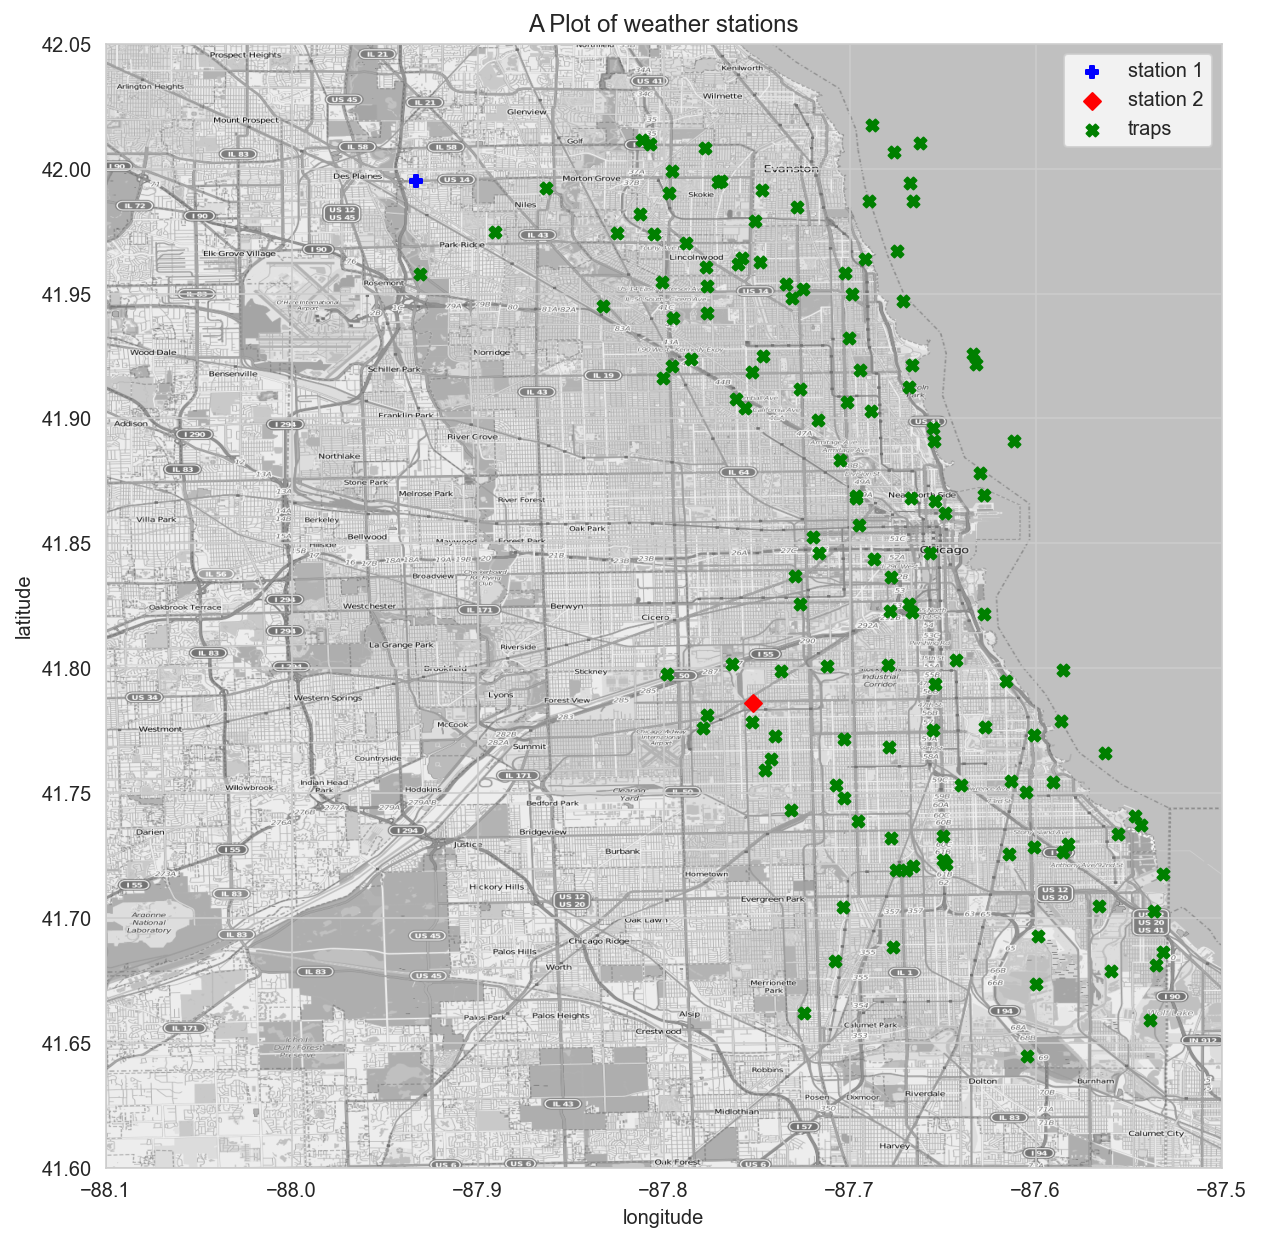

In [10]:
map_data()

Based on the map above, I would group like following:
```
├── weather data station 1
    ├── train data
        ├── longitude: -88.0 to -87.6
        └── latitude: 41.9 to 42.05
├── weather data station 2
    ├── train data
        ├── longitude: -87.9 to -87.5
        └── latitude: 41.60 to 41.89 
```

Since `train.csv` only contains 2007, 2009, 2011 and 2013 data while `weather.csv` contains consecutive years, I will be taking subsets of weather data to join with train data, making sure that same days and trap locations near respective weather stations get consistent weather reference.

In [11]:
w_df.columns

Index(['Station', 'Tmax', 'Tmin', 'Tavg', 'Depart', 'DewPoint', 'WetBulb',
       'Heat', 'Cool', 'Sunrise', 'Sunset', 'CodeSum', 'Depth', 'Water1',
       'SnowFall', 'PrecipTotal', 'StnPressure', 'SeaLevel', 'ResultSpeed',
       'ResultDir', 'AvgSpeed'],
      dtype='object')

In [12]:
# choose what features to retain for merging

# for train
t_formerge = t_df.drop(columns=['Address','Block','Street',
                                'AddressNumberAndStreet','AddressAccuracy'])
display(t_formerge.head(3))
# 'CodeSum' can be tokenized and countvectorized, the information could be useful
w_formerge = w_df.drop(columns=['Depart','Heat','Cool','Sunrise','Sunset',
                                'Depth','Water1','SnowFall'])
# dropping Depth, Water1 and SnowFall since station 2 is missing that data
# also wish to minimise noise in data
display(w_formerge.head(3))

,Species,Trap,Latitude,Longitude,NumMosquitos,WnvPresent
Date,,,,,,
2007-05-29,CULEX PIPIENS/RESTUANS,T002,41.954690,-87.800991,1,0
2007-05-29,CULEX RESTUANS,T002,41.954690,-87.800991,1,0
2007-05-29,CULEX RESTUANS,T007,41.994991,-87.769279,1,0


,Station,Tmax,Tmin,Tavg,DewPoint,WetBulb,CodeSum,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
Date,,,,,,,,,,,,,
2007-05-01,1,83,50,67,51,56,NaN,0.00,29.10,29.82,1.7,27,9.2
2007-05-01,2,84,52,68,51,57,NaN,0.00,29.18,29.82,2.7,25,9.6
2007-05-02,1,59,42,51,42,47,BR,0.00,29.38,30.09,13.0,4,13.4


In [13]:
# now to split weather data by station
w1_formerge = w_formerge.loc[w_formerge['Station']==1,:]
display(w1_formerge.head(3))
display(w1_formerge.shape)
w2_formerge = w_formerge.loc[w_formerge['Station']==2,:]
display(w2_formerge.head(3))
display(w2_formerge.shape)

,Station,Tmax,Tmin,Tavg,DewPoint,WetBulb,CodeSum,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
Date,,,,,,,,,,,,,
2007-05-01,1,83,50,67,51,56,NaN,0.00,29.10,29.82,1.7,27,9.2
2007-05-02,1,59,42,51,42,47,BR,0.00,29.38,30.09,13.0,4,13.4
2007-05-03,1,66,46,56,40,48,NaN,0.00,29.39,30.12,11.7,7,11.9


(1472, 13)

,Station,Tmax,Tmin,Tavg,DewPoint,WetBulb,CodeSum,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
Date,,,,,,,,,,,,,
2007-05-01,2,84,52,68,51,57,NaN,0.00,29.18,29.82,2.7,25,9.6
2007-05-02,2,60,43,52,42,47,BR HZ,0.00,29.44,30.08,13.3,2,13.4
2007-05-03,2,67,48,58,40,50,HZ,0.00,29.46,30.12,12.9,6,13.2


(1472, 13)

In [14]:
# split train data based on coordinates
# for station 1
t1_formerge = t_formerge.loc[(t_formerge['Latitude']>=41.9) & (t_formerge['Latitude']<=42.05) 
                            & (t_formerge['Longitude']>=-88.0) & (t_formerge['Longitude']<=-87.6),
                             :]
display(t1_formerge.head(3))
display(t1_formerge.shape)
# for station 2
t2_formerge = t_formerge.loc[(t_formerge['Latitude']>=41.6) & (t_formerge['Latitude']<41.9) 
                            & (t_formerge['Longitude']>=-87.9) & (t_formerge['Longitude']<=-87.5),
                             :]
display(t2_formerge.head(3))
display(t2_formerge.shape)
display(t_formerge.shape)
# check no overlap traps
4223 + 6283 # no overlap

,Species,Trap,Latitude,Longitude,NumMosquitos,WnvPresent
Date,,,,,,
2007-05-29,CULEX PIPIENS/RESTUANS,T002,41.954690,-87.800991,1,0
2007-05-29,CULEX RESTUANS,T002,41.954690,-87.800991,1,0
2007-05-29,CULEX RESTUANS,T007,41.994991,-87.769279,1,0


(4223, 6)

,Species,Trap,Latitude,Longitude,NumMosquitos,WnvPresent
Date,,,,,,
2007-05-29,CULEX RESTUANS,T046,41.891118,-87.654491,1,0
2007-05-29,CULEX PIPIENS/RESTUANS,T048,41.867108,-87.654224,1,0
2007-05-29,CULEX RESTUANS,T048,41.867108,-87.654224,2,0


(6283, 6)

(10506, 6)

10506

In [15]:
# now can combine by station
# merge by station 1
station1 = pd.merge(right=t1_formerge,
                   left=w1_formerge,
                   how='right', # since train data has narrower date range
                   right_index=True,
                   left_index=True)
display(station1.head(3))
display(station1.shape) # didnt lose any rows after merge

# merge by station 2
station2 = pd.merge(right=t2_formerge,
                   left=w2_formerge, 
                   how='right',
                   right_index=True,
                   left_index=True)
display(station2.head(3))
display(station2.shape) # didnt lose any rows after merge

,Station,Tmax,Tmin,Tavg,DewPoint,WetBulb,CodeSum,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed,Species,Trap,Latitude,Longitude,NumMosquitos,WnvPresent
Date,,,,,,,,,,,,,,,,,,,
2007-05-29,1,88,60,74,58,65,BR HZ,0.00,29.39,30.11,5.8,18,6.5,CULEX PIPIENS/RESTUANS,T002,41.954690,-87.800991,1,0
2007-05-29,1,88,60,74,58,65,BR HZ,0.00,29.39,30.11,5.8,18,6.5,CULEX RESTUANS,T002,41.954690,-87.800991,1,0
2007-05-29,1,88,60,74,58,65,BR HZ,0.00,29.39,30.11,5.8,18,6.5,CULEX RESTUANS,T007,41.994991,-87.769279,1,0


(4223, 19)

,Station,Tmax,Tmin,Tavg,DewPoint,WetBulb,CodeSum,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed,Species,Trap,Latitude,Longitude,NumMosquitos,WnvPresent
Date,,,,,,,,,,,,,,,,,,,
2007-05-29,2,88,65,77,59,66,BR HZ,0.00,29.44,30.09,5.8,16,7.4,CULEX RESTUANS,T046,41.891118,-87.654491,1,0
2007-05-29,2,88,65,77,59,66,BR HZ,0.00,29.44,30.09,5.8,16,7.4,CULEX PIPIENS/RESTUANS,T048,41.867108,-87.654224,1,0
2007-05-29,2,88,65,77,59,66,BR HZ,0.00,29.44,30.09,5.8,16,7.4,CULEX RESTUANS,T048,41.867108,-87.654224,2,0


(6283, 19)

In [16]:
# now to combine via concat
wt_df = pd.concat([station1, station2], axis=0)
# sort index by date
wt_df.sort_index(inplace=True)
display(wt_df.shape)
display(wt_df.head(3))

(10506, 19)

,Station,Tmax,Tmin,Tavg,DewPoint,WetBulb,CodeSum,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed,Species,Trap,Latitude,Longitude,NumMosquitos,WnvPresent
Date,,,,,,,,,,,,,,,,,,,
2007-05-29,1,88,60,74,58,65,BR HZ,0.00,29.39,30.11,5.8,18,6.5,CULEX PIPIENS/RESTUANS,T002,41.954690,-87.800991,1,0
2007-05-29,2,88,65,77,59,66,BR HZ,0.00,29.44,30.09,5.8,16,7.4,CULEX RESTUANS,T048,41.867108,-87.654224,2,0
2007-05-29,2,88,65,77,59,66,BR HZ,0.00,29.44,30.09,5.8,16,7.4,CULEX RESTUANS,T049,41.896282,-87.655232,1,0


In [17]:
# check year range
wt_df.resample('Y').agg({'Station':'count'})
# just confirming still 2007, 2009, 2011, 2013

,Station
Date,
2007-12-31,3811
2008-12-31,0
2009-12-31,2249
2010-12-31,0
2011-12-31,2054
2012-12-31,0
2013-12-31,2392


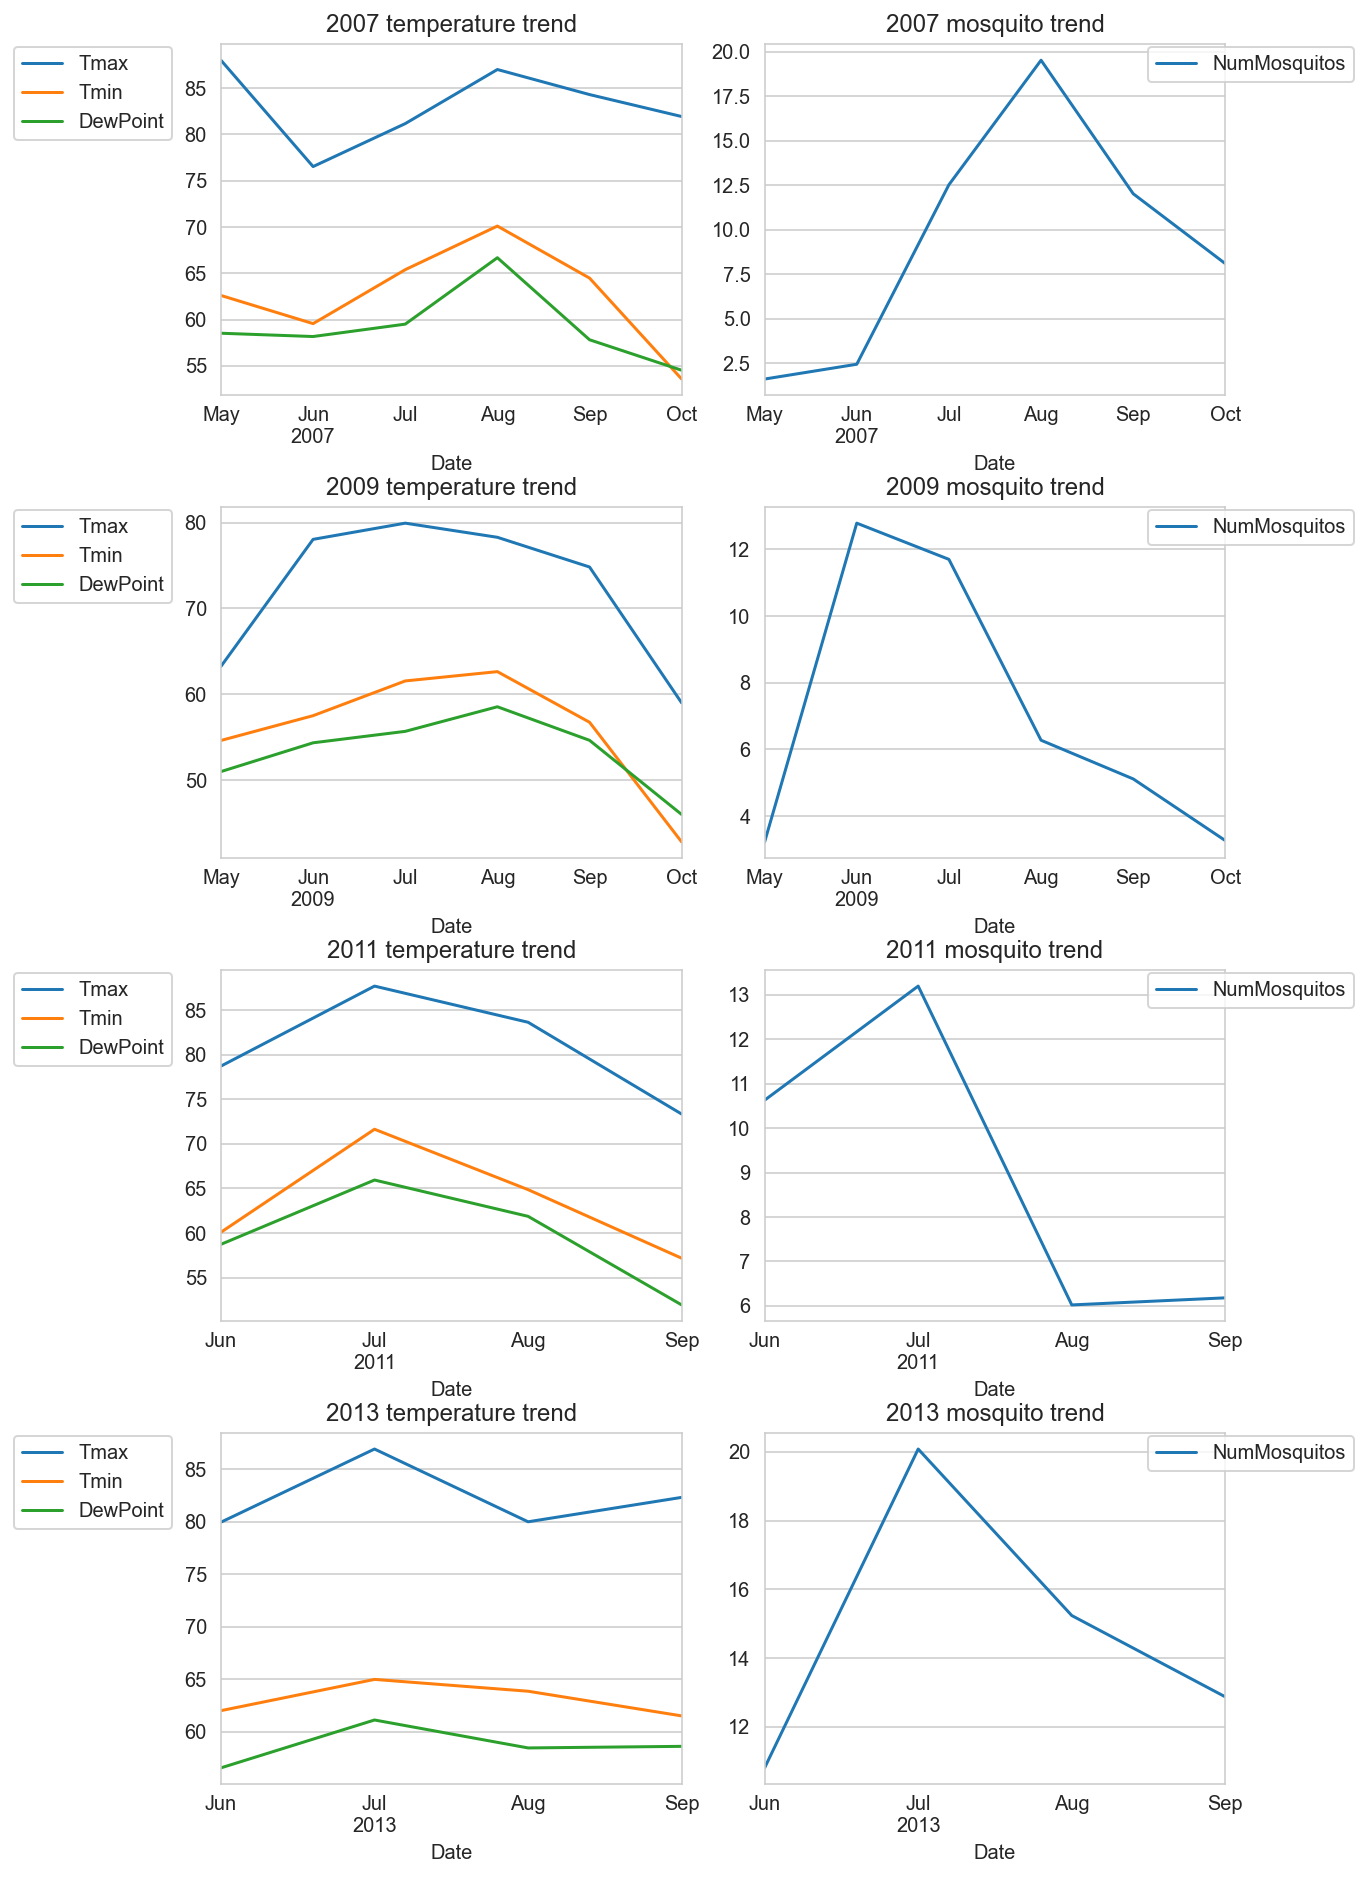

In [80]:
# do a plot with subplots to compare each year trend in mosquito number and temp
# need to split mosquito number and temp axis for better visual

# find out if temperature has effect on mosquito count
# groupby month
def mosto_temp(year, ax1, ax2):
    wt_df.loc[year].resample('M').agg({'Tmax':'mean','Tmin':'mean','DewPoint':'mean'}).plot(kind='line',
                                                                                          ax=ax1,
                                                                                          figsize=(9,16))
    wt_df.loc[year].resample('M').agg({'NumMosquitos':'mean'}).plot(kind='line',
                                                                 ax=ax2,
                                                                 figsize=(9,16));
##################    
fig, axes = plt.subplots(4, 2) # 4 rows, 2 columns plot grid

mosto_temp('2007', ax1=axes[0,0], ax2=axes[0,1])
axes[0,0].set_title('2007 temperature trend')
axes[0,1].set_title('2007 mosquito trend')
mosto_temp('2009', ax1=axes[1,0], ax2=axes[1,1])
axes[1,0].set_title('2009 temperature trend')
axes[1,1].set_title('2009 mosquito trend')
mosto_temp('2011', ax1=axes[2,0], ax2=axes[2,1])
axes[2,0].set_title('2011 temperature trend')
axes[2,1].set_title('2011 mosquito trend')
mosto_temp('2013', ax1=axes[3,0], ax2=axes[3,1])
axes[3,0].set_title('2013 temperature trend')
axes[3,1].set_title('2013 mosquito trend')

# to iterate subplot legend in each column, define position
for ax in [axes.flat[0], axes.flat[2], axes.flat[4], axes.flat[6]]: 
    ax.legend(labels=['Tmax','Tmin','DewPoint'], loc='upper left', bbox_to_anchor=(-0.47, 1.02))
for ax in [axes.flat[1], axes.flat[3], axes.flat[5], axes.flat[7]]: 
    ax.legend(labels=['NumMosquitos'], loc='upper right', bbox_to_anchor=(1.3, 1.02))
    
plt.subplots_adjust(wspace=0.18, hspace=0.32) # space between subplots
plt.savefig('./images/temp_mosquitonum.jpeg')

Based on the graphs above, there is an association between temperature and mosquito population.

In [19]:
# if humidity / rainfall has any effect on mosquito count (based by 2 regions North and South)

In [20]:
# account for null values before CountVectorizing
wt_df['CodeSum'] = wt_df['CodeSum'].fillna('M')

In [21]:
# check filling
display(wt_df['CodeSum'].isnull().sum())
display(wt_df['CodeSum'])

0

Date
2007-05-29    BR HZ
2007-05-29    BR HZ
2007-05-29    BR HZ
2007-05-29    BR HZ
2007-05-29    BR HZ
              ...  
2013-09-26       BR
2013-09-26       BR
2013-09-26       BR
2013-09-26       BR
2013-09-26        M
Name: CodeSum, Length: 10506, dtype: object

In [22]:
# using countvectorizer to do one-hot encoding of CodeSum
# usually will do train-test-split first before countvectorizing for NLP problems
# however this is not an NLP problem, 
# and the codes in CodeSum is used consistently across train, test, validation sets
# so doing this here should not cause false performance results in machine learning
from sklearn.feature_extraction.text import CountVectorizer
# instantiate countvectorizer
def vectorizer(col):
    cvec = CountVectorizer(lowercase=False, 
                           ngram_range=(1,1), 
                           token_pattern=r'[a-zA-Z]+'
                          )
    # fit-transform 'CodeSum' feature
    cvec_df = pd.DataFrame(cvec.fit_transform(wt_df[col]).todense(),
                           columns=cvec.get_feature_names_out())
    return cvec_df

cvec_wt = vectorizer(col='CodeSum')
display(cvec_wt.shape) # only 9 unique values on record
display(cvec_wt.head(3))

(10506, 9)

,BR,DZ,FG,HZ,M,RA,TS,TSRA,VCTS
0,1,0,0,1,0,0,0,0,0
1,1,0,0,1,0,0,0,0,0
2,1,0,0,1,0,0,0,0,0


In [23]:
# notice that TSRA and VCTS are just combinations so I need to split them up in text
import re
def tokenizer(data):
    new_data = re.findall(r'(\w{1,2})', data)
    return ' '.join(new_data)

wt_df['CodeSum'] = wt_df['CodeSum'].apply(tokenizer)
display(wt_df['CodeSum'])

Date
2007-05-29    BR HZ
2007-05-29    BR HZ
2007-05-29    BR HZ
2007-05-29    BR HZ
2007-05-29    BR HZ
              ...  
2013-09-26       BR
2013-09-26       BR
2013-09-26       BR
2013-09-26       BR
2013-09-26        M
Name: CodeSum, Length: 10506, dtype: object

In [24]:
# repeat
# instantiate vectorizer function
cvec_wt = vectorizer(col='CodeSum')
display(cvec_wt.shape) # now only 8 unique values on record now
display(cvec_wt.head(3)) # preview

(10506, 8)

,BR,DZ,FG,HZ,M,RA,TS,VC
0,1,0,0,1,0,0,0,0
1,1,0,0,1,0,0,0,0
2,1,0,0,1,0,0,0,0


In [25]:
# now to Countvectorize the Species feature
cvec_sp = vectorizer(col='Species')
cvec_sp.drop(columns=['CULEX'], inplace=True) # drop 'CULEX' since it is common for all species in this data
display(cvec_sp.shape) # 6 unique values on record
display(cvec_sp.head(3)) # preview

(10506, 6)

,ERRATICUS,PIPIENS,RESTUANS,SALINARIUS,TARSALIS,TERRITANS
0,0,1,1,0,0,0
1,0,0,1,0,0,0
2,0,0,1,0,0,0


In [26]:
# join cvec_sp and cvec_wt with main frame

# cannot concat all 3 at once due to date index in main frame, throws errors regarding indexing
# use merge instead
sp_wt = pd.concat([cvec_sp, cvec_wt], axis=1) # 14 features
sp_wt = sp_wt.set_index(wt_df.index.copy()) # need this step before merging, otherwise throw error
wt_df1 = pd.concat([wt_df, sp_wt], axis=1) # merge kept giving cross join, so used concat
wt_df1.drop(columns=['CodeSum','Species'], inplace=True) # drop duplicates
display(wt_df1.shape)
display(wt_df1.head(3))
display(wt_df1.tail(3))

(10506, 31)

,Station,Tmax,Tmin,Tavg,DewPoint,WetBulb,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,...,TARSALIS,TERRITANS,BR,DZ,FG,HZ,M,RA,TS,VC
Date,,,,,,,,,,,,,,,,,,,,,
2007-05-29,1,88,60,74,58,65,0.00,29.39,30.11,5.8,...,0,0,1,0,0,1,0,0,0,0
2007-05-29,2,88,65,77,59,66,0.00,29.44,30.09,5.8,...,0,0,1,0,0,1,0,0,0,0
2007-05-29,2,88,65,77,59,66,0.00,29.44,30.09,5.8,...,0,0,1,0,0,1,0,0,0,0


,Station,Tmax,Tmin,Tavg,DewPoint,WetBulb,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,...,TARSALIS,TERRITANS,BR,DZ,FG,HZ,M,RA,TS,VC
Date,,,,,,,,,,,,,,,,,,,,,
2013-09-26,1,75,50,63,52,58,0.00,29.34,30.04,3.8,...,0,0,1,0,0,0,0,0,0,0
2013-09-26,1,75,50,63,52,58,0.00,29.34,30.04,3.8,...,0,0,1,0,0,0,0,0,0,0
2013-09-26,2,75,55,65,52,58,0.00,29.40,30.04,4.1,...,0,0,0,0,0,0,1,0,0,0


In [27]:
wt_df1['PrecipTotal'].value_counts(dropna=False)

0.00    5949
  T      879
0.01     272
0.23     251
0.06     235
0.09     181
0.83     172
0.36     163
0.16     158
0.02     146
0.88     137
0.84     117
0.03     115
0.20     115
0.92     106
0.08      96
0.12      82
1.31      80
0.13      74
0.58      73
0.17      72
0.39      72
0.24      71
0.70      70
0.11      67
0.59      63
1.55      61
0.33      56
0.14      55
0.50      53
0.87      52
0.79      49
0.52      44
3.97      41
0.19      38
0.42      36
0.04      34
1.19      30
0.89      26
0.95      24
0.27      24
0.46      23
M         21
0.44      18
0.05       3
0.37       2
Name: PrecipTotal, dtype: int64

In [28]:
# replace T with 0.00
# remove rows with missing data 'M'
# convert to float
wt_df1.loc[wt_df1['PrecipTotal']=='  T', ['PrecipTotal']]= 0.00
wt_df1 = wt_df1[wt_df1['PrecipTotal'] != 'M']
wt_df1['PrecipTotal'] = wt_df1['PrecipTotal'].astype('float64')

In [29]:
# check changes
display(wt_df1.shape)
display(wt_df1['PrecipTotal'].value_counts())

(10485, 31)

0.00    6828
0.01     272
0.23     251
0.06     235
0.09     181
0.83     172
0.36     163
0.16     158
0.02     146
0.88     137
0.84     117
0.20     115
0.03     115
0.92     106
0.08      96
0.12      82
1.31      80
0.13      74
0.58      73
0.17      72
0.39      72
0.24      71
0.70      70
0.11      67
0.59      63
1.55      61
0.33      56
0.14      55
0.50      53
0.87      52
0.79      49
0.52      44
3.97      41
0.19      38
0.42      36
0.04      34
1.19      30
0.89      26
0.95      24
0.27      24
0.46      23
0.44      18
0.05       3
0.37       2
Name: PrecipTotal, dtype: int64

Wet Bulb temperature:
> Wet bulb temperature essentially measures how much water vapor the atmosphere can hold at current weather conditions. A lower wet bulb temperature means the air is drier and can hold more water vapor than it can at a higher wet bulb temperature. 

[Reference](https://deltacooling.com/resources/news/understanding-wet-bulb-temperatures-and-how-it-affects-cooling-tower-performance)

Dew Point temperature:
> The higher the dew point rises, the greater the amount of moisture in the air.

[Reference](https://www.weather.gov/arx/why_dewpoint_vs_humidity#:~:text=The%20higher%20the%20dew%20point,relative%20humidity%20can%20be%20misleading)

In [30]:
wt_df1['WetBulb'].value_counts() # there are 'M' values in 'WetBulb' feature

70    901
69    892
62    825
71    745
65    589
72    524
64    510
67    471
68    467
63    446
61    389
59    366
74    342
57    342
58    339
66    329
60    248
75    244
76    184
47    181
73    165
49    160
51    148
54    136
56    134
50    130
52    101
55     93
M      44
53     26
46     14
Name: WetBulb, dtype: int64

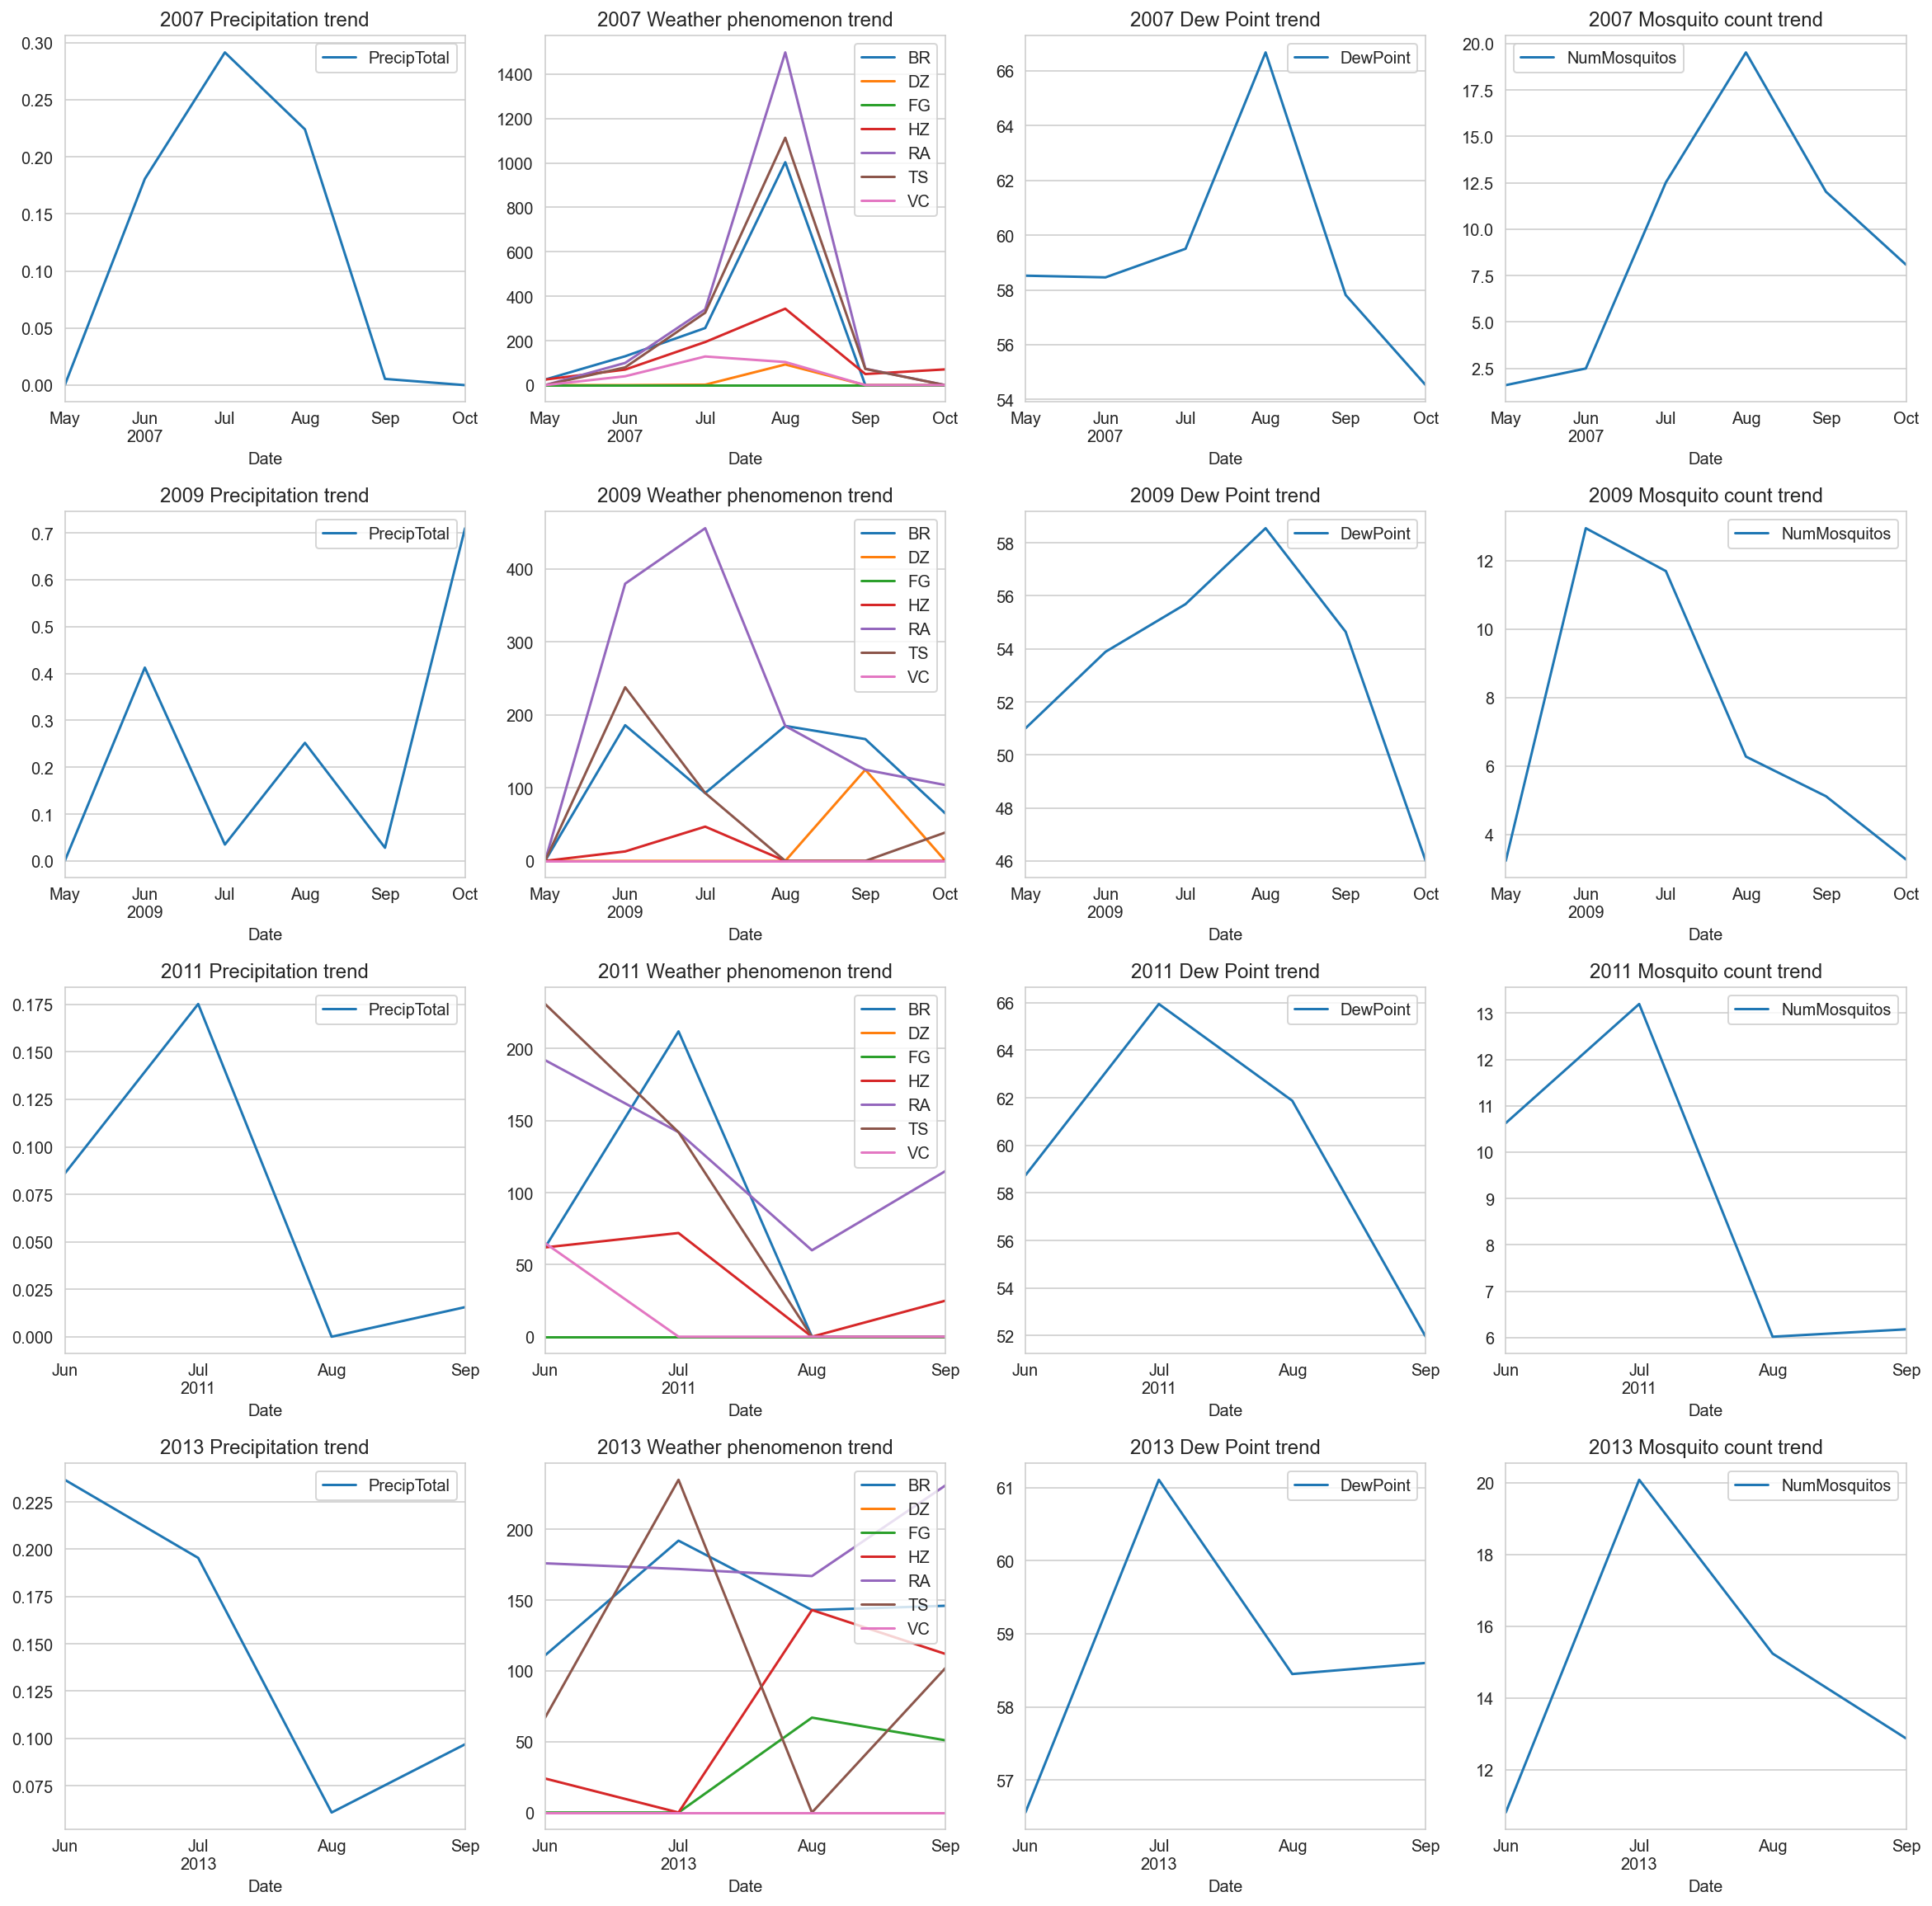

In [81]:
# to plot precipitation sum, cvec_wt sum vs. nummosquitos
# plotting does not accept non-numeric values
def humidity_mosto(year,ax1,ax2,ax3,ax4):
    wt_df1.loc[year].resample('M').agg({'PrecipTotal': 'mean'}).plot(kind='line',
                                                                    figsize=(20,20),
                                                                      ax=ax1);
    wt_df1.loc[year].resample('M').agg({'BR':'sum','DZ':'sum','FG':'sum','HZ':'sum','RA':'sum','TS':'sum','VC':'sum'}).plot(kind='line',
                                                                                                                            figsize=(20,20),
                                                                                                                             ax=ax2);
    wt_df1.loc[year].resample('M').agg({'DewPoint':'mean'}).plot(kind='line',
                                                                figsize=(20,20),
                                                                 ax=ax3) # did not use wetbulb due to 'M' values
    wt_df1.loc[year].resample('M').agg({'NumMosquitos':'mean'}).plot(kind='line',
                                                                figsize=(20,20),
                                                                ax=ax4)

def humidity_mosto_titles(year,ax1,ax2,ax3,ax4):
    ax1.set_title(f'{year} Precipitation trend')
    ax2.set_title(f'{year} Weather phenomenon trend')
    ax3.set_title(f'{year} Dew Point trend')
    ax4.set_title(f'{year} Mosquito count trend')

######################
fig, axes = plt.subplots(4,4) # 4 rows, 4 columns plot grid

humidity_mosto('2007',ax1=axes[0,0], ax2=axes[0,1], ax3=axes[0,2], ax4=axes[0,3])
humidity_mosto_titles('2007',ax1=axes[0,0], ax2=axes[0,1], ax3=axes[0,2], ax4=axes[0,3])
humidity_mosto('2009',ax1=axes[1,0], ax2=axes[1,1], ax3=axes[1,2], ax4=axes[1,3])
humidity_mosto_titles('2009',ax1=axes[1,0], ax2=axes[1,1], ax3=axes[1,2], ax4=axes[1,3])
humidity_mosto('2011',ax1=axes[2,0], ax2=axes[2,1], ax3=axes[2,2], ax4=axes[2,3])
humidity_mosto_titles('2011',ax1=axes[2,0], ax2=axes[2,1], ax3=axes[2,2], ax4=axes[2,3])
humidity_mosto('2013',ax1=axes[3,0], ax2=axes[3,1], ax3=axes[3,2], ax4=axes[3,3])
humidity_mosto_titles('2013',ax1=axes[3,0], ax2=axes[3,1], ax3=axes[3,2], ax4=axes[3,3])

plt.subplots_adjust(hspace=0.3) # space between subplots
plt.savefig('./images/humidity_mosquitonum.jpeg')

In [38]:
# find out if StnPressure, sea level has a relationship with nummosquitos

# first must try convert object dtypes to float by removing 'M' values
# find out how many will be removed
display(len(wt_df1.loc[wt_df1['StnPressure']=='M', ['StnPressure']])) # 44 missing values
display(len(wt_df1.loc[wt_df1['SeaLevel']=='M', ['SeaLevel']])) # no missing values

44

0

In [40]:
# drop StnPressure values = 'M'
wt_df1 = wt_df1[wt_df1['StnPressure'] != 'M']

In [42]:
# convert dtype
wt_df1['StnPressure'] = wt_df1['StnPressure'].astype('float64')
wt_df1['SeaLevel'] = wt_df1['SeaLevel'].astype('float64')

In [47]:
wt_df1.info() # check change

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10441 entries, 2007-05-29 to 2013-09-26
Data columns (total 31 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Station       10441 non-null  int64  
 1   Tmax          10441 non-null  int64  
 2   Tmin          10441 non-null  int64  
 3   Tavg          10441 non-null  object 
 4   DewPoint      10441 non-null  int64  
 5   WetBulb       10441 non-null  object 
 6   PrecipTotal   10441 non-null  float64
 7   StnPressure   10441 non-null  float64
 8   SeaLevel      10441 non-null  float64
 9   ResultSpeed   10441 non-null  float64
 10  ResultDir     10441 non-null  int64  
 11  AvgSpeed      10441 non-null  object 
 12  Trap          10441 non-null  object 
 13  Latitude      10441 non-null  float64
 14  Longitude     10441 non-null  float64
 15  NumMosquitos  10441 non-null  int64  
 16  WnvPresent    10441 non-null  int64  
 17  ERRATICUS     10441 non-null  int64  
 18  PIPIENS  

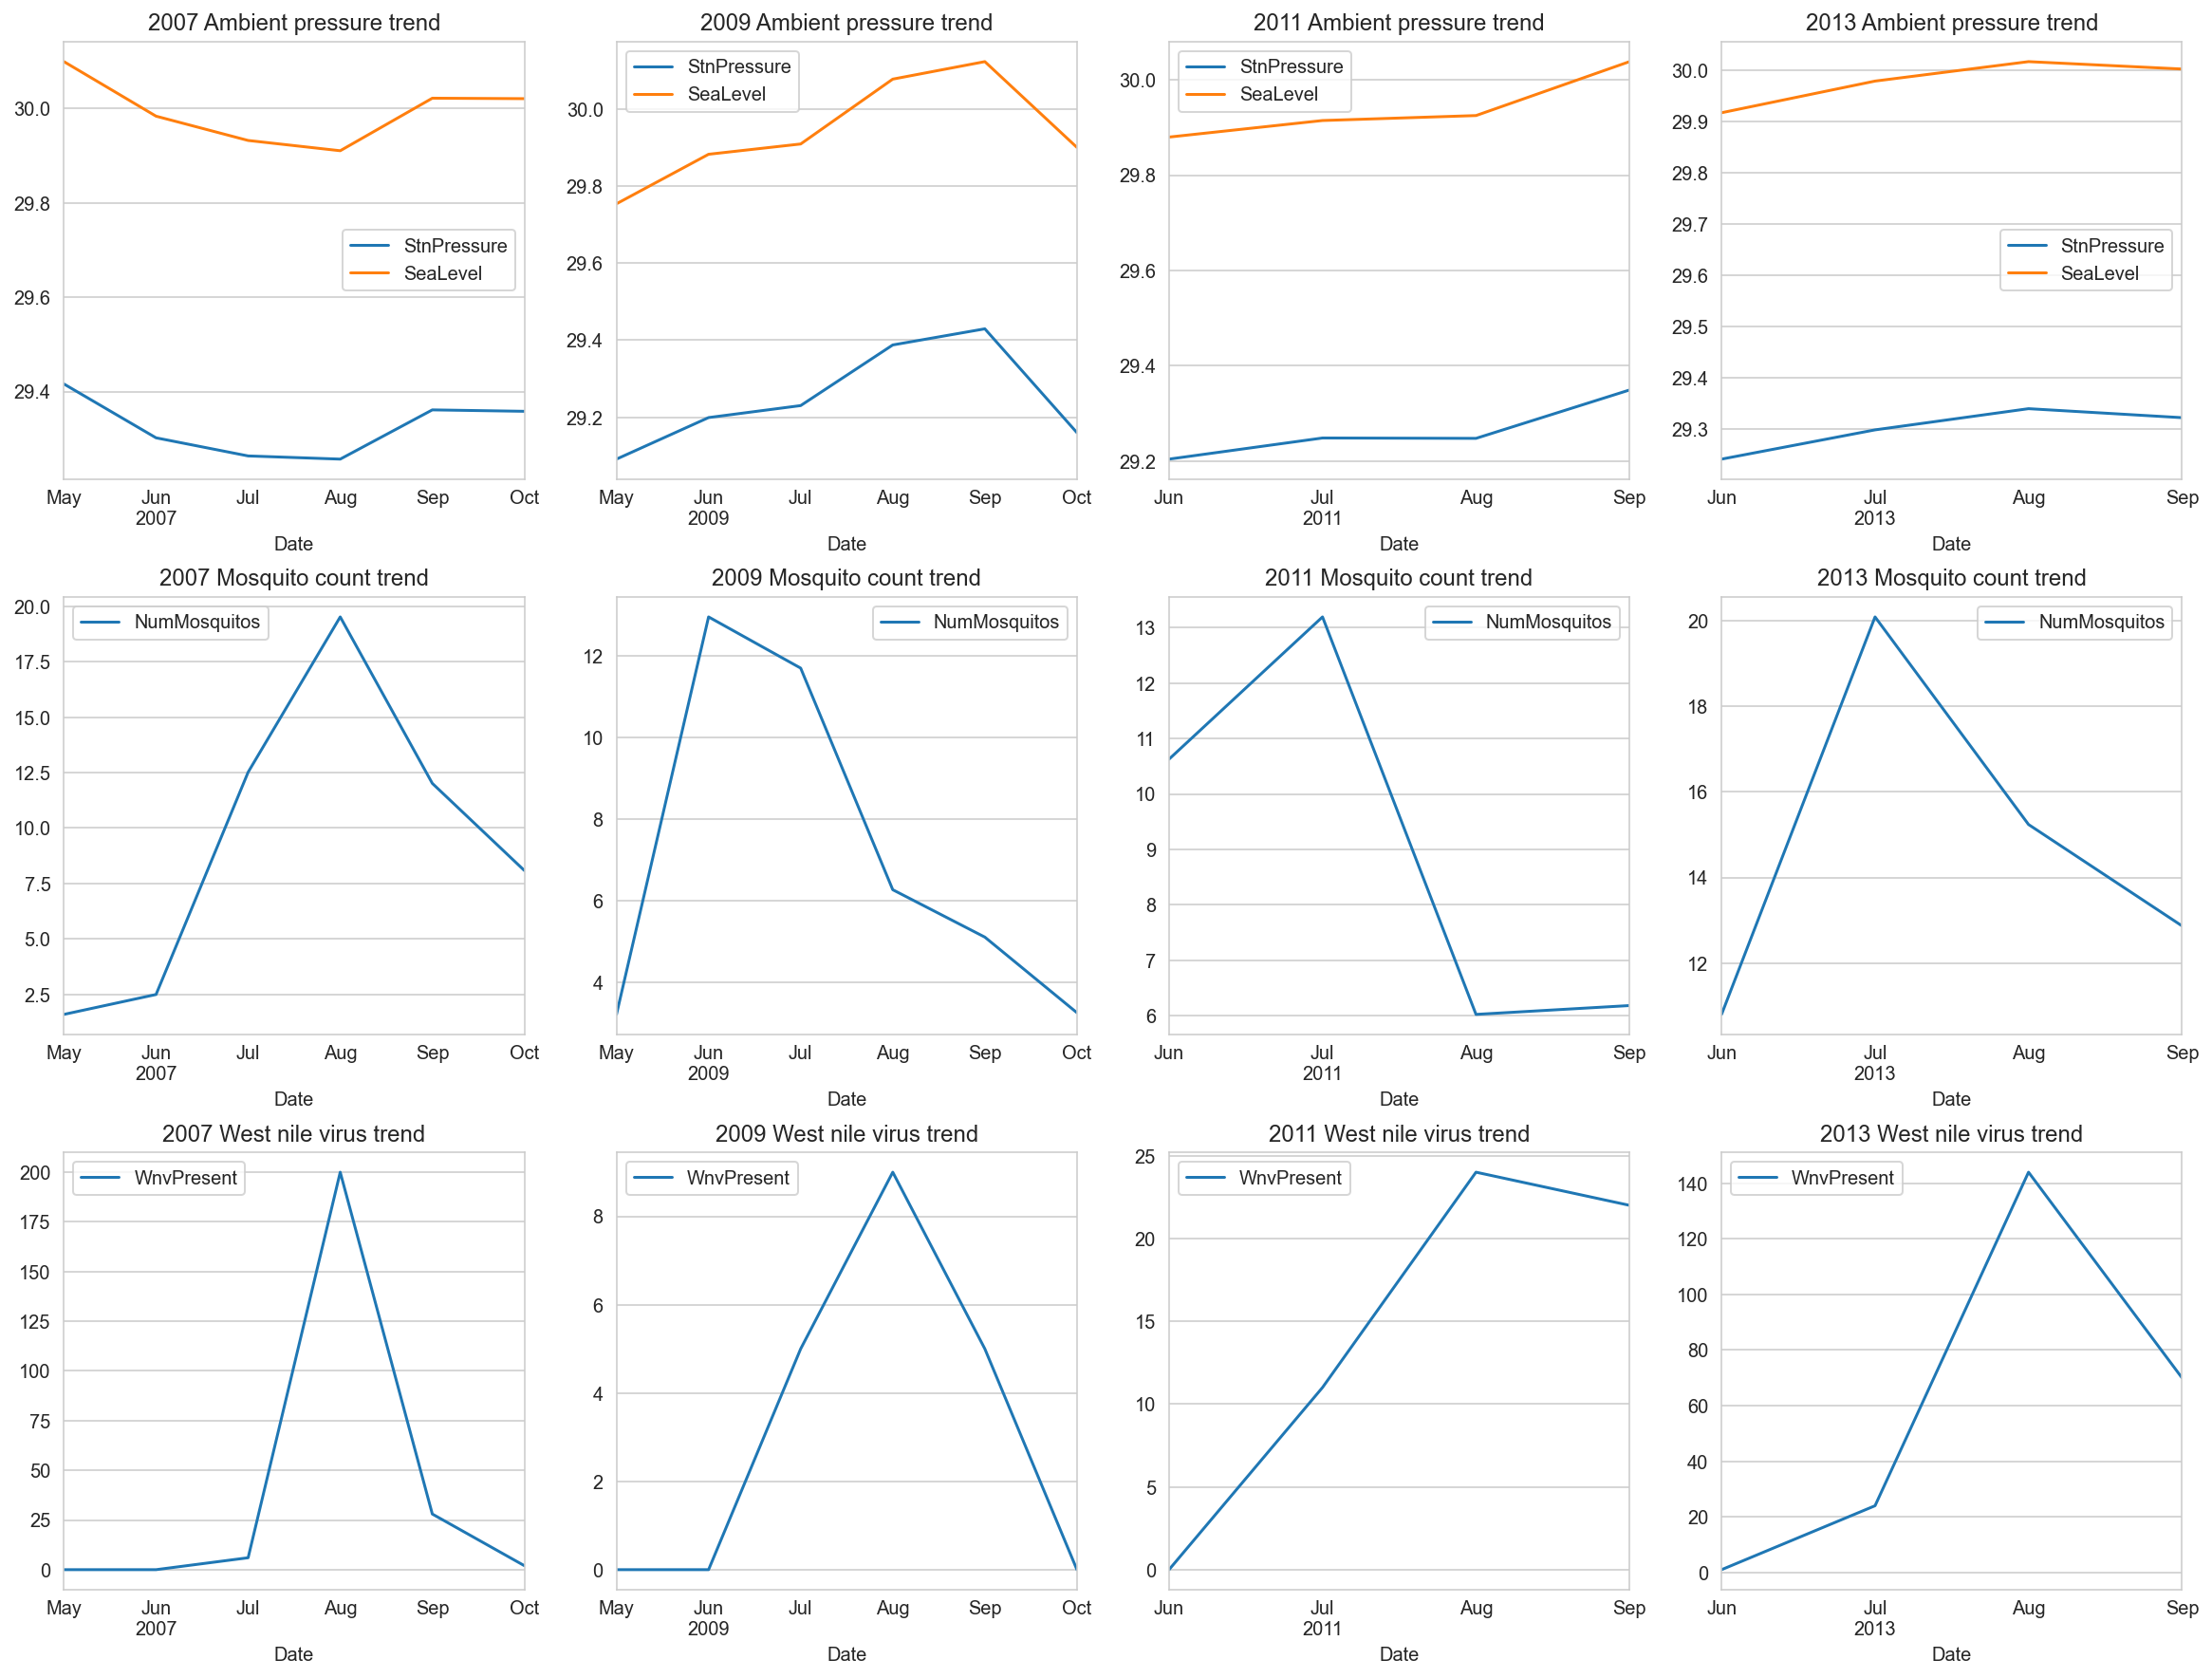

In [84]:
# find out if StnPressure, sea level has a relationship with nummosquitos
# pressure and sealevel sum have very different trend to its mean

def pressure_mosto(year,ax1,ax2,ax3):
    wt_df1.loc[year].resample('M').agg({'StnPressure':'mean','SeaLevel':'mean'}).plot(kind='line',
                                                                                    figsize=(20,15),
                                                                                    ax=ax1);
    wt_df1.loc[year].resample('M').agg({'NumMosquitos':'mean'}).plot(kind='line',
                                                                    figsize=(20,15),
                                                                    ax=ax2);
    wt_df1.loc[year].resample('M').agg({'WnvPresent':'sum'}).plot(kind='line',
                                                                  figsize=(20,15),
                                                                  ax=ax3);

def pressure_mosto_titles(year,ax1,ax2,ax3):
    ax1.set_title(f'{year} Ambient pressure trend')
    ax2.set_title(f'{year} Mosquito count trend')
    ax3.set_title(f'{year} West nile virus trend')
    
#########################
fig, axes = plt.subplots(3,4) # 3 rows, 4 columns plot grid

pressure_mosto('2007',ax1=axes[0,0],ax2=axes[1,0],ax3=axes[2,0])
pressure_mosto_titles('2007',ax1=axes[0,0],ax2=axes[1,0],ax3=axes[2,0])
pressure_mosto('2009',ax1=axes[0,1],ax2=axes[1,1],ax3=axes[2,1])
pressure_mosto_titles('2009',ax1=axes[0,1],ax2=axes[1,1],ax3=axes[2,1])
pressure_mosto('2011',ax1=axes[0,2],ax2=axes[1,2],ax3=axes[2,2])
pressure_mosto_titles('2011',ax1=axes[0,2],ax2=axes[1,2],ax3=axes[2,2])
pressure_mosto('2013',ax1=axes[0,3],ax2=axes[1,3],ax3=axes[2,3])
pressure_mosto_titles('2013',ax1=axes[0,3],ax2=axes[1,3],ax3=axes[2,3])

plt.subplots_adjust(hspace=0.27) # space between subplots
plt.savefig('./images/pressure_mosquitonum.jpeg')

Atmospheric pressure effect on mosquito population
> There is a close relationship between atmospheric pressure and mosquito population density since both total and specific larval densities increase as atmospheric pressure increases.

[Reference](https://www.redalyc.org/journal/5763/576366658009/html/)

My plots do not support the theory mentioned in the reference.

In [67]:
# find out if wind speeds have relationship with nummosquitos

# first, need to find out if any 'M' values in AvgSpeed since it was classified object dtype 
# by pandas
len(wt_df1.loc[wt_df1['AvgSpeed']=='M', ['AvgSpeed']])  # there is none

0

In [68]:
# convert dtype
wt_df1['AvgSpeed'] = wt_df1['AvgSpeed'].astype('float64')

In [69]:
wt_df1.info() # check change

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10441 entries, 2007-05-29 to 2013-09-26
Data columns (total 31 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Station       10441 non-null  int64  
 1   Tmax          10441 non-null  int64  
 2   Tmin          10441 non-null  int64  
 3   Tavg          10441 non-null  object 
 4   DewPoint      10441 non-null  int64  
 5   WetBulb       10441 non-null  object 
 6   PrecipTotal   10441 non-null  float64
 7   StnPressure   10441 non-null  float64
 8   SeaLevel      10441 non-null  float64
 9   ResultSpeed   10441 non-null  float64
 10  ResultDir     10441 non-null  int64  
 11  AvgSpeed      10441 non-null  float64
 12  Trap          10441 non-null  object 
 13  Latitude      10441 non-null  float64
 14  Longitude     10441 non-null  float64
 15  NumMosquitos  10441 non-null  int64  
 16  WnvPresent    10441 non-null  int64  
 17  ERRATICUS     10441 non-null  int64  
 18  PIPIENS  

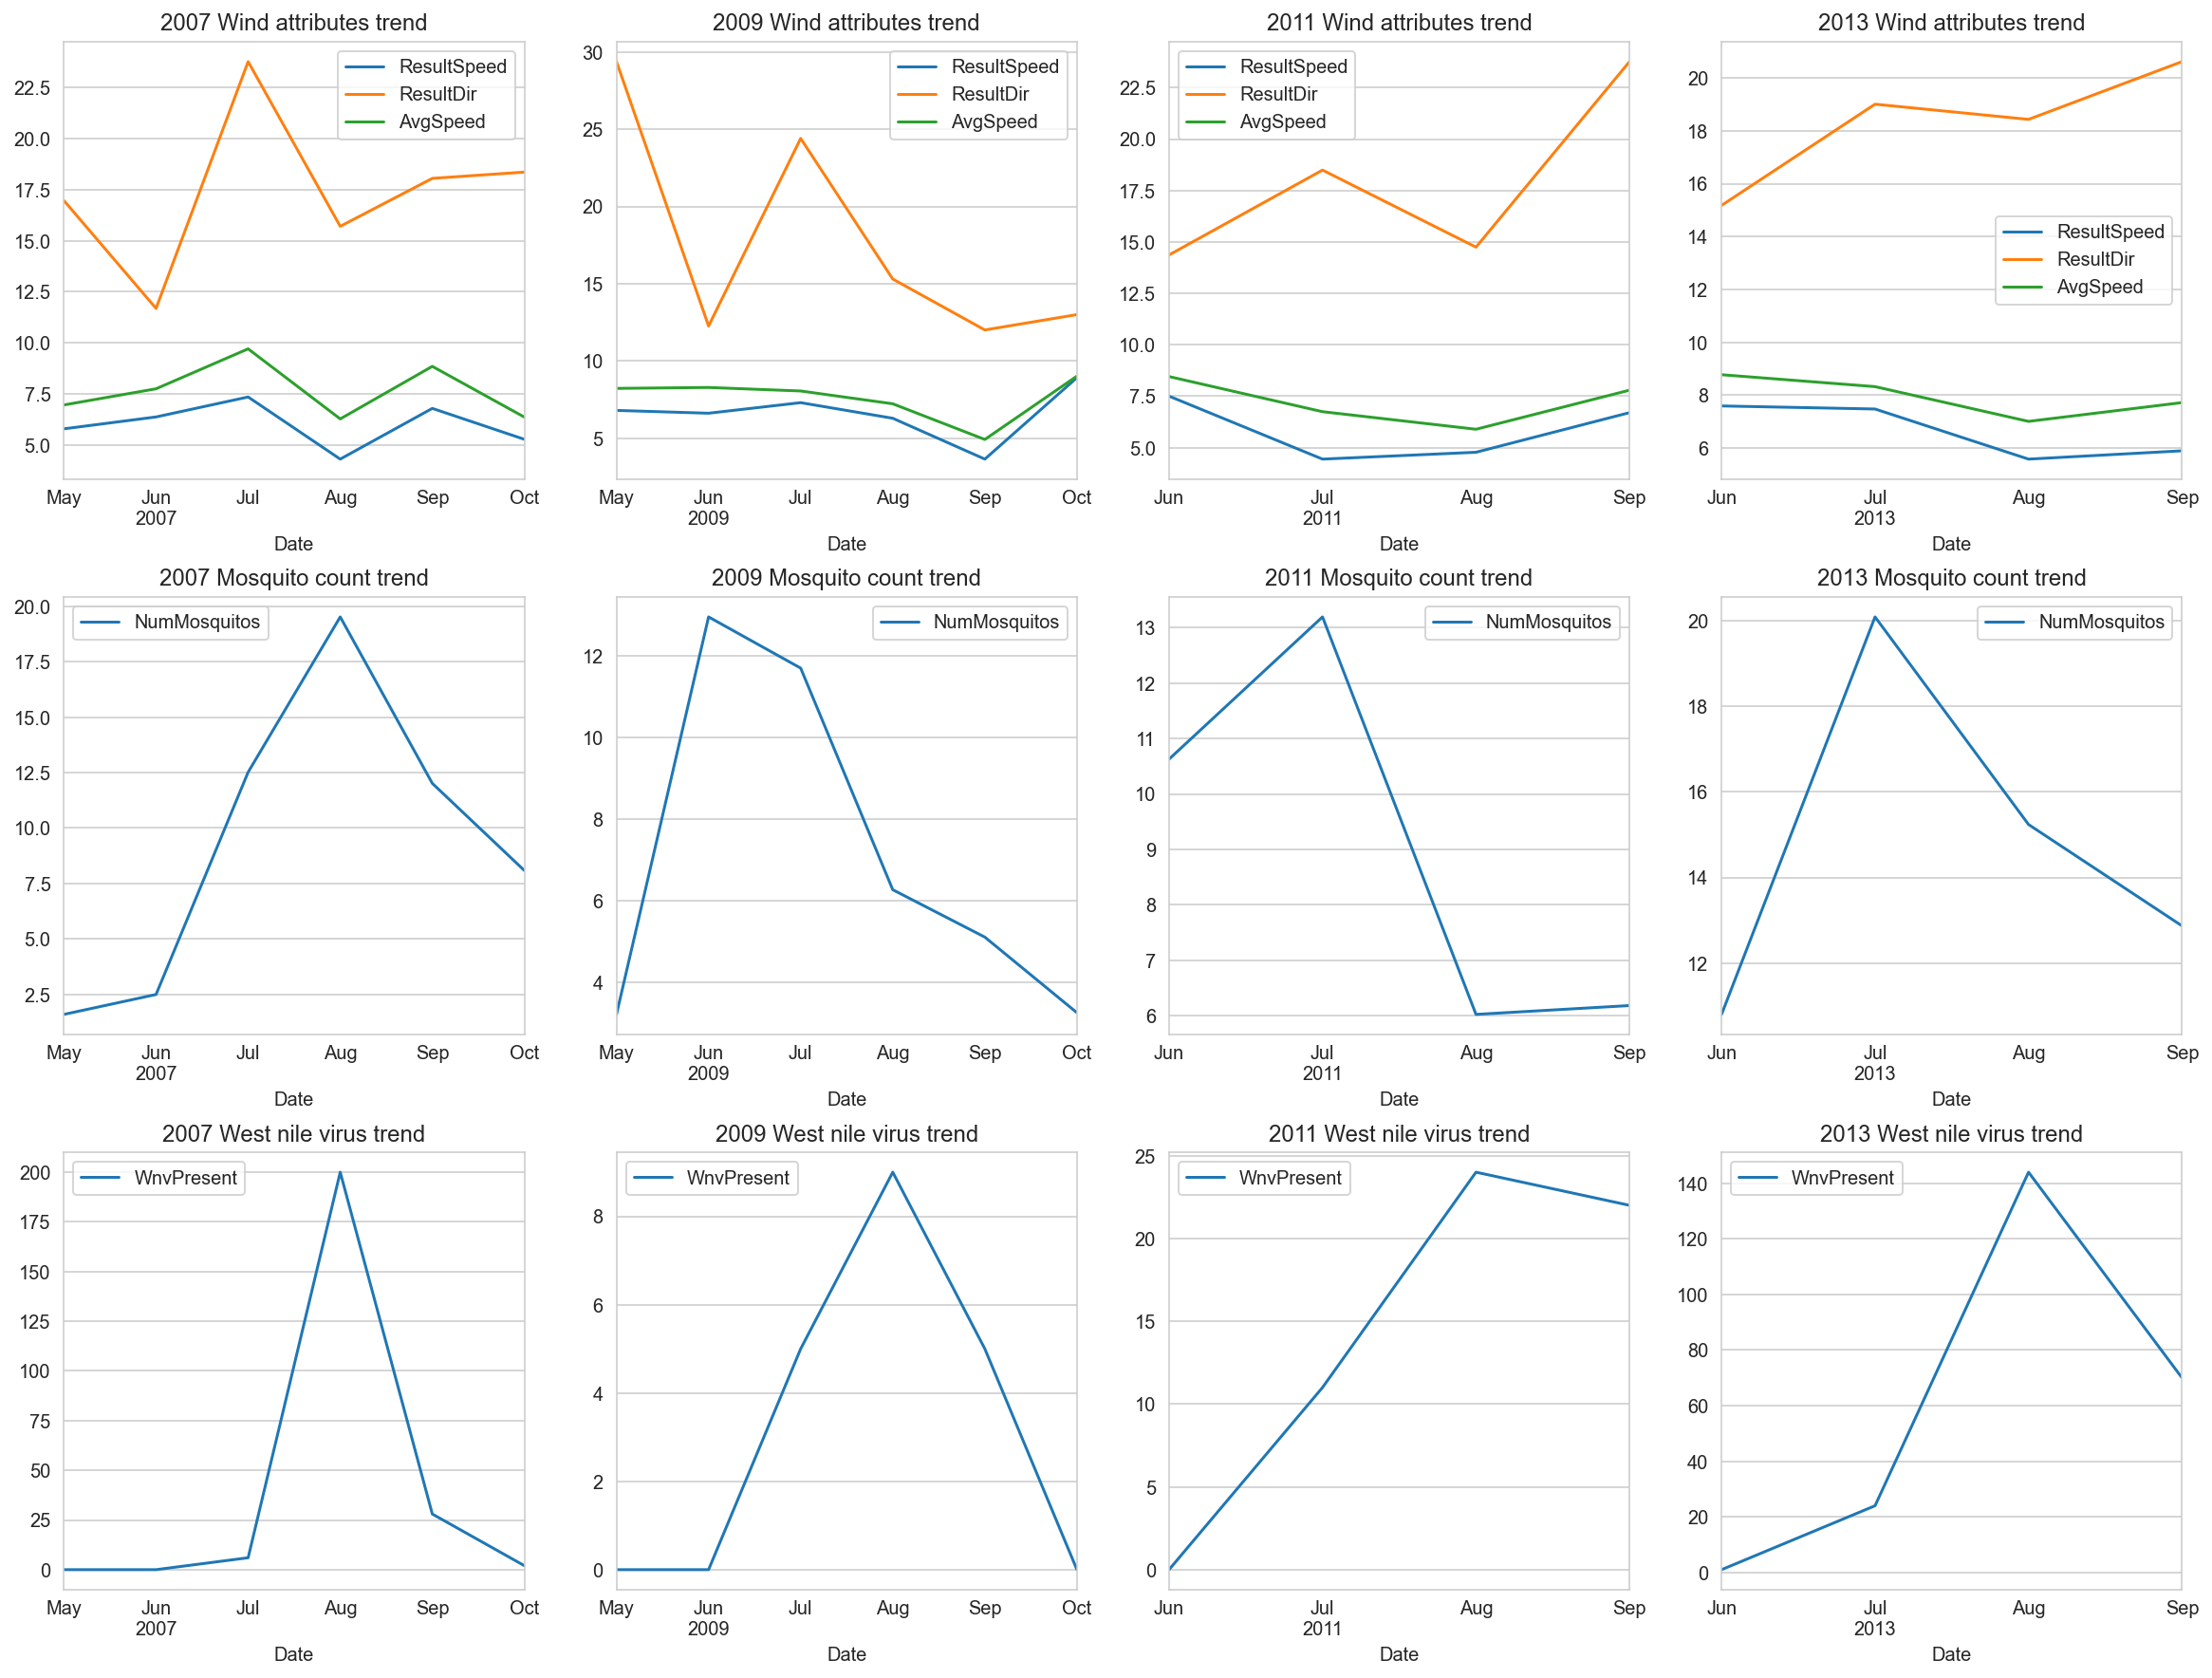

In [87]:
# find out if wind speeds have relationship with nummosquitos
def wind_mosto(year,ax1,ax2,ax3):
    wt_df1.loc[year].resample('M').agg({'ResultSpeed':'mean','ResultDir':'mean','AvgSpeed':'mean'}).plot(kind='line',
                                                                                                         figsize=(20,15),
                                                                                                         ax=ax1);
    wt_df1.loc[year].resample('M').agg({'NumMosquitos':'mean'}).plot(kind='line',
                                                                    figsize=(20,15),
                                                                    ax=ax2);
    wt_df1.loc[year].resample('M').agg({'WnvPresent':'sum'}).plot(kind='line',
                                                                  figsize=(20,15),
                                                                  ax=ax3);
def wind_mosto_titles(year,ax1,ax2,ax3):
    ax1.set_title(f'{year} Wind attributes trend')
    ax2.set_title(f'{year} Mosquito count trend')
    ax3.set_title(f'{year} West nile virus trend')
    
####################
fig, axes = plt.subplots(3,4) # 2 rows, 4 columns plot grid

wind_mosto('2007', ax1=axes[0,0], ax2=axes[1,0], ax3=axes[2,0])
wind_mosto_titles('2007', ax1=axes[0,0], ax2=axes[1,0], ax3=axes[2,0])
wind_mosto('2009', ax1=axes[0,1], ax2=axes[1,1], ax3=axes[2,1])
wind_mosto_titles('2009', ax1=axes[0,1], ax2=axes[1,1], ax3=axes[2,1])
wind_mosto('2011', ax1=axes[0,2], ax2=axes[1,2], ax3=axes[2,2])
wind_mosto_titles('2011', ax1=axes[0,2], ax2=axes[1,2], ax3=axes[2,2])
wind_mosto('2013', ax1=axes[0,3], ax2=axes[1,3], ax3=axes[2,3])
wind_mosto_titles('2013', ax1=axes[0,3], ax2=axes[1,3], ax3=axes[2,3])

plt.subplots_adjust(hspace=0.27) # space between subplots
plt.savefig('./images/wind_mosquitonum.jpeg')

Wind speeds effect on mosquito growth
> Wind-induced waves in a reservoir impose mortality on aquatic-stage mosquitoes. Mosquitoes’ host-seeking activity is also influenced by wind through dispersion of CO$_2$.

[Reference](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5784732/)

If based on the reference quoted above, then my plots above does not support that theory. 

if mosquito count is related to probability of being west nile virus positive

    Based on the plots above, for 2009, 2011 and 2013, there is an inverse relationship between positive west nile virus results and mosquito average count. However for 2007, there is a direct relationship. So there is inconsistency, more data is needed to find out which trend is true.